### Librerías

In [149]:
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from sklearn.model_selection import train_test_split
from datetime import timedelta
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

######### Matriz de confusion ##############
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [172]:
url = 'https://raw.githubusercontent.com/DavidValGon/DS_LATAM/main/dataset_SCL.csv'
df = pd.read_csv(url, sep = ";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Observación: no hay valores nulos

In [173]:
df["Fecha-I-DMA"]=pd.to_datetime(df["Fecha-I"], format ="%d/%m/%Y %H:%M")
df["Fecha-O"]=pd.to_datetime(df["Fecha-O"], format ="%d/%m/%Y %H:%M")
df["Fecha-I"]=pd.to_datetime(df["Fecha-I"], format ="%d/%m/%Y %H:%M")
df["Fecha-I-DMA"]=df["Fecha-I-DMA"].dt.strftime('%d/%m/%Y') 
df["Fecha-temp"]=df['Fecha-I'].dt.month*100+df['Fecha-I'].dt.day
df['hora_min'] = df['Fecha-I'].dt.hour*100+df['Fecha-I'].dt.minute

In [174]:
df["dif"]= df["Fecha-O"] - df["Fecha-I"]
df["dif_min"]= df["dif"] / np.timedelta64(1, 'm')
df['atraso_15'] = np.where(df['dif_min']>15, 1, 0)
df['atraso_1'] = np.where(df['dif_min']>0, 1, 0)
df['hora'] = df['Fecha-I'].dt.hour
df['temporada_alta'] = df['Fecha-temp'].apply(lambda x: 1 if x >= 1215 else (1 if x <= 303 else (1 if (x >= 715 and x <= 731) else (1 if (x >= 911 and x <= 930) else 0))))
df['periodo_dia'] = df['hora'].apply(lambda x: "mañana" if (x >= 5 and x <= 11) else ("tarde" if (x >= 12 and x <= 18) else "noche"))
df['Vlo-I'] = df['Vlo-I'].astype(str)
df['Vlo-I'] = df['Vlo-I'].str.replace(r'\D+', "0")
df['Vlo-I'] = df['Vlo-I'].astype(int)
df['Vlo-O'] = df['Vlo-O'].astype(str)
df['Vlo-O'] = df['Vlo-O'].str.replace(r'\D+', "0")
df['Vlo-O'] = df['Vlo-O'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   Fecha-I         68206 non-null  datetime64[ns] 
 1   Vlo-I           68206 non-null  int64          
 2   Ori-I           68206 non-null  object         
 3   Des-I           68206 non-null  object         
 4   Emp-I           68206 non-null  object         
 5   Fecha-O         68206 non-null  datetime64[ns] 
 6   Vlo-O           68206 non-null  int64          
 7   Ori-O           68206 non-null  object         
 8   Des-O           68206 non-null  object         
 9   Emp-O           68206 non-null  object         
 10  DIA             68206 non-null  int64          
 11  MES             68206 non-null  int64          
 12  AÑO             68206 non-null  int64          
 13  DIANOM          68206 non-null  object         
 14  TIPOVUELO       68206 non-null  object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


In [175]:
print(df.dtypes)
print(df.head(20))

Fecha-I            datetime64[ns]
Vlo-I                       int64
Ori-I                      object
Des-I                      object
Emp-I                      object
Fecha-O            datetime64[ns]
Vlo-O                       int64
Ori-O                      object
Des-O                      object
Emp-O                      object
DIA                         int64
MES                         int64
AÑO                         int64
DIANOM                     object
TIPOVUELO                  object
OPERA                      object
SIGLAORI                   object
SIGLADES                   object
Fecha-I-DMA                object
Fecha-temp                  int64
hora_min                    int64
dif               timedelta64[ns]
dif_min                   float64
atraso_15                   int64
atraso_1                    int64
hora                        int64
temporada_alta              int64
periodo_dia                object
dtype: object
               Fecha-I  Vlo-I Ori-

In [176]:
df = df.drop(["Fecha-I","Ori-I","Des-I","Emp-I","Fecha-O","Ori-O","Des-O","Emp-O", "Fecha-I-DMA","SIGLAORI","AÑO", "dif", "hora"], axis = 1)

In [177]:
print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES     DIANOM TIPOVUELO              OPERA SIGLADES  \
0    226    226    1    1    Domingo         I  American Airlines    Miami   
1    226    226    2    1      Lunes         I  American Airlines    Miami   
2    226    226    3    1     Martes         I  American Airlines    Miami   
3    226    226    4    1  Miercoles         I  American Airlines    Miami   
4    226    226    5    1     Jueves         I  American Airlines    Miami   

   Fecha-temp  hora_min  dif_min  atraso_15  atraso_1  temporada_alta  \
0         101      2330      3.0          0         1               1   
1         102      2330      9.0          0         1               1   
2         103      2330      9.0          0         1               1   
3         104      2330      3.0          0         1               1   
4         105      2330     -2.0          0         0               1   

  periodo_dia  
0       noche  
1       noche  
2       noche  
3       noche  
4       noch

In [178]:
df['DIANOM_ENCOD'] = df['DIANOM'].map( {"Lunes" : 1,
"Martes" : 2,
"Miercoles" : 3,
"Jueves" : 4,
"Viernes" : 5,
"Sabado" : 6,
"Domingo" : 7} ).astype(int)

df['TIPOVUELO_ENCOD'] = df['TIPOVUELO'].map( {"N" : 0,
"I" : 1} ).astype(int)

df['OPERA_ENCOD'] = df['OPERA'].map( {"American Airlines" : 1,
"Air Canada" : 2,
"Air France" : 3,
"Aeromexico" : 4,
"Aerolineas Argentinas" : 5,
"Austral" : 6,
"Avianca" : 7,
"Alitalia" : 8,
"British Airways" : 9,
"Copa Air" : 10,
"Delta Air" : 11,
"Gol Trans" : 12,
"Iberia" : 13,
"K.L.M." : 14,
"Qantas Airways" : 15,
"United Airlines" : 16,
"Grupo LATAM" : 17,
"Sky Airline" : 18,
"Latin American Wings" : 19,
"Plus Ultra Lineas Aereas" : 20,
"JetSmart SPA" : 21,
"Oceanair Linhas Aereas" : 22,
"Lacsa" : 23} ).astype(int)

df['SIGLADES_ENCOD'] = df['SIGLADES'].map( {"Miami" : 1,
"Dallas" : 2,
"Buenos Aires" : 3,
"Toronto" : 4,
"Paris" : 5,
"Ciudad de Mexico" : 6,
"Bogota" : 7,
"Roma" : 8,
"Londres" : 9,
"Ciudad de Panama" : 10,
"Atlanta" : 11,
"Sao Paulo" : 12,
"Rio de Janeiro" : 13,
"Florianapolis" : 14,
"Madrid" : 15,
"Lima" : 16,
"Sydney" : 17,
"Houston" : 18,
"Asuncion" : 19,
"Cataratas Iguacu" : 20,
"Puerto Montt" : 21,
"Punta Arenas" : 22,
"Puerto Natales" : 23,
"Balmaceda" : 24,
"Temuco" : 25,
"Valdivia" : 26,
"Concepcion" : 27,
"La Serena" : 28,
"Copiapo" : 29,
"Calama" : 30,
"Antofagasta" : 31,
"Iquique" : 32,
"Arica" : 33,
"Mendoza" : 34,
"Cordoba" : 35,
"Montevideo" : 36,
"Castro (Chiloe)" : 37,
"Osorno" : 38,
"Orlando" : 39,
"Nueva York" : 40,
"Guayaquil" : 41,
"Cancun" : 42,
"Punta Cana" : 43,
"Los Angeles" : 44,
"Auckland N.Z." : 45,
"Isla de Pascua" : 46,
"La Paz" : 47,
"Santa Cruz" : 48,
"Curitiba, Bra." : 49,
"Quito" : 50,
"Bariloche" : 51,
"Rosario" : 52,
"Washington" : 53,
"Tucuman" : 54,
"Melbourne" : 55,
"San Juan, Arg." : 56,
"Neuquen" : 57,
"Pisco, Peru" : 58,
"Ushuia" : 59,
"Puerto Stanley" : 60,
"Punta del Este" : 61,
"Cochabamba" : 62} ).astype(int)

df['periodo_dia_ENCOD'] = df['periodo_dia'].map( {"mañana" : 1,
"tarde" : 2,
"noche" : 3} ).astype(int)

In [179]:
print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES     DIANOM TIPOVUELO              OPERA SIGLADES  \
0    226    226    1    1    Domingo         I  American Airlines    Miami   
1    226    226    2    1      Lunes         I  American Airlines    Miami   
2    226    226    3    1     Martes         I  American Airlines    Miami   
3    226    226    4    1  Miercoles         I  American Airlines    Miami   
4    226    226    5    1     Jueves         I  American Airlines    Miami   

   Fecha-temp  hora_min  dif_min  atraso_15  atraso_1  temporada_alta  \
0         101      2330      3.0          0         1               1   
1         102      2330      9.0          0         1               1   
2         103      2330      9.0          0         1               1   
3         104      2330      3.0          0         1               1   
4         105      2330     -2.0          0         0               1   

  periodo_dia  DIANOM_ENCOD  TIPOVUELO_ENCOD  OPERA_ENCOD  SIGLADES_ENCOD  \
0       noche  

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Vlo-I              68206 non-null  int64  
 1   Vlo-O              68206 non-null  int64  
 2   DIA                68206 non-null  int64  
 3   MES                68206 non-null  int64  
 4   DIANOM             68206 non-null  object 
 5   TIPOVUELO          68206 non-null  object 
 6   OPERA              68206 non-null  object 
 7   SIGLADES           68206 non-null  object 
 8   Fecha-temp         68206 non-null  int64  
 9   hora_min           68206 non-null  int64  
 10  dif_min            68206 non-null  float64
 11  atraso_15          68206 non-null  int64  
 12  atraso_1           68206 non-null  int64  
 13  temporada_alta     68206 non-null  int64  
 14  periodo_dia        68206 non-null  object 
 15  DIANOM_ENCOD       68206 non-null  int64  
 16  TIPOVUELO_ENCOD    682

In [159]:
Mayor_1 = sum(df.atraso_1)/len(df)
Mayor_15 = sum(df.atraso_15)/len(df)
print(Mayor_1)
print(Mayor_15)

0.6671993666246371
0.18493974137172683


In [160]:
df["dif_min"].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

(array([  770.,  1398.,  5342., 10400., 15701.,  8143.,  7734.,  3936.,
         3819.,  1877.,  1829.,  1045.,  1014.,   608.,   647.,   415.,
          434.,   267.,   318.,   197.,   261.,   160.,   209.,   118.,
          133.,   116.,   117.,    91.,   112.,    79.,    76.,    67.,
           85.,    46.,    77.,    52.,    52.,    47.,    68.,    35.,
           43.,    32.,    43.,    17.,    33.,    18.,    30.,    30.,
           27.,    38.]),
 array([-14. , -10.5,  -7. ,  -3.5,   0. ,   3.5,   7. ,  10.5,  14. ,
         17.5,  21. ,  24.5,  28. ,  31.5,  35. ,  38.5,  42. ,  45.5,
         49. ,  52.5,  56. ,  59.5,  63. ,  66.5,  70. ,  73.5,  77. ,
         80.5,  84. ,  87.5,  91. ,  94.5,  98. , 101.5, 105. , 108.5,
        112. , 115.5, 119. , 122.5, 126. , 129.5, 133. , 136.5, 140. ,
        143.5, 147. , 150.5, 154. , 157.5, 161. ]),
 <a list of 50 Patch objects>)

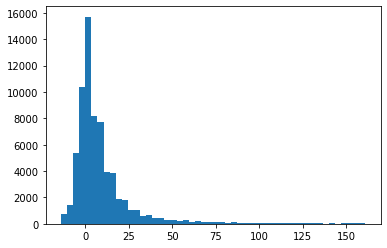

In [132]:
plt.hist(df["dif_min"], bins=50)

Distribución de datos

In [61]:
df_atraso_15_aero = df.groupby("SIGLADES")[["atraso_15"]].mean()
df_atraso_15_aero.head(10)

,atraso_15
SIGLADES,
Antofagasta,0.146388
Arica,0.135468
Asuncion,0.284483
Atlanta,0.058659
Auckland N.Z.,0.373961
Balmaceda,0.146603
Bariloche,0.500000
Bogota,0.258728
Buenos Aires,0.255722


In [63]:
df_atraso_1_aero = df.groupby("SIGLADES")[["atraso_1"]].mean()
df_atraso_1_aero.head(10)

,atraso_1
SIGLADES,
Antofagasta,0.607847
Arica,0.639984
Asuncion,0.814655
Atlanta,0.307263
Auckland N.Z.,0.850416
Balmaceda,0.748510
Bariloche,1.000000
Bogota,0.652120
Buenos Aires,0.719021


In [17]:
df_atraso_1_linea = df.groupby("OPERA")[["atraso_1"]].mean()
df_atraso_1_linea.head(10)

,atraso_1
OPERA,
Aerolineas Argentinas,0.591072
Aeromexico,0.222222
Air Canada,0.775221
Air France,0.421788
Alitalia,0.579151
American Airlines,0.284016
Austral,0.648649
Avianca,0.572917
British Airways,0.604878


In [18]:
df_atraso_15_linea = df.groupby("OPERA")[["atraso_15"]].mean()
df_atraso_15_linea.head(10)

,atraso_15
OPERA,
Aerolineas Argentinas,0.240123
Aeromexico,0.028490
Air Canada,0.456637
Air France,0.083799
Alitalia,0.111969
American Airlines,0.067371
Austral,0.202703
Avianca,0.265625
British Airways,0.141463


In [19]:
df_atraso_1_mes = df.groupby("MES")[["atraso_1"]].mean()
df_atraso_1_mes.head(12)

,atraso_1
MES,
1,0.661755
2,0.652401
3,0.565669
4,0.592430
5,0.641221
6,0.648464
7,0.770027
8,0.647110
9,0.645455


In [20]:
df_atraso_15_mes = df.groupby("MES")[["atraso_15"]].mean()
df_atraso_15_mes.head(12)

,atraso_15
MES,
1,0.160118
2,0.151591
3,0.115104
4,0.116534
5,0.157824
6,0.171050
7,0.293391
8,0.173398
9,0.172371


In [21]:
df_atraso_1_dia = df.groupby("DIANOM")[["atraso_1"]].mean()
df_atraso_1_dia.head(12)

,atraso_1
DIANOM,
Domingo,0.639241
Jueves,0.683543
Lunes,0.675155
Martes,0.642310
Miercoles,0.659947
Sabado,0.645953
Viernes,0.717159


In [22]:
df_atraso_15_dia = df.groupby("DIANOM")[["atraso_15"]].mean()
df_atraso_15_dia.head(7)

,atraso_15
DIANOM,
Domingo,0.161086
Jueves,0.199493
Lunes,0.202152
Martes,0.169116
Miercoles,0.170850
Sabado,0.163194
Viernes,0.222017


In [23]:
df_atraso_1_tem = df.groupby("temporada_alta")[["atraso_1"]].mean()
df_atraso_1_tem.head(2)

,atraso_1
temporada_alta,
0,0.659031
1,0.683508


In [24]:
df_atraso_15_tem = df.groupby("temporada_alta")[["atraso_15"]].mean()
df_atraso_15_tem.head(2)

,atraso_15
temporada_alta,
0,0.17921
1,0.19638


In [25]:
df_atraso_1_vuelo = df.groupby("TIPOVUELO")[["atraso_1"]].mean()
df_atraso_1_vuelo.head(2)

,atraso_1
TIPOVUELO,
I,0.678521
N,0.657631


In [26]:
df_atraso_15_vuelo = df.groupby("TIPOVUELO")[["atraso_15"]].mean()
df_atraso_15_vuelo.head(2)

,atraso_15
TIPOVUELO,
I,0.225608
N,0.150571


In [181]:
df = df.drop(["DIANOM", "TIPOVUELO", "OPERA", "SIGLADES", "periodo_dia", "dif_min", "atraso_1"], axis = 1)

print(df.head(5))

   Vlo-I  Vlo-O  DIA  MES  Fecha-temp  hora_min  atraso_15  temporada_alta  \
0    226    226    1    1         101      2330          0               1   
1    226    226    2    1         102      2330          0               1   
2    226    226    3    1         103      2330          0               1   
3    226    226    4    1         104      2330          0               1   
4    226    226    5    1         105      2330          0               1   

   DIANOM_ENCOD  TIPOVUELO_ENCOD  OPERA_ENCOD  SIGLADES_ENCOD  \
0             7                1            1               1   
1             1                1            1               1   
2             2                1            1               1   
3             3                1            1               1   
4             4                1            1               1   

   periodo_dia_ENCOD  
0                  3  
1                  3  
2                  3  
3                  3  
4                  3  


In [182]:
varObjetivoE = df.iloc[0,6]
varObjetivoE

0

In [184]:
inicio = datetime.now()

numFolds=20

X = datos
X = X.drop(['atraso_15'], axis=1)

#Crear objeto k-fold cross validation
kf = KFold(n_splits=numFolds, shuffle=True)
temp=kf.split(X)

allF1Test=np.zeros((numFolds,1))
allF1Train=np.zeros((numFolds,1))
allAcc=np.zeros((numFolds,1))
allRecall=np.zeros((numFolds,1))
allPrecision=np.zeros((numFolds,1))

index=0
for train_index, test_index in temp:
    
    #Crear Arbol
    arbolModel = DecisionTreeClassifier()
    
    varIndependienteE = X.iloc[train_index,:]#Extraer datos variables independientes
    varObjetivoE = datos.iloc[train_index,6]#Extraer dato variables dependientes  

    #Entrenar modelo
    arbolModel = arbolModel.fit(varIndependienteE,varObjetivoE)   
    prediccionE = arbolModel.predict(varIndependienteE)    
    allF1Train[index]=f1_score(varObjetivoE,prediccionE,pos_label=False)

    #Predecir
    varIndependienteT = X.iloc[test_index,:]
    varObjetivoT = datos.iloc[test_index,6]
    prediccionT = arbolModel.predict(varIndependienteT)
    
    allF1Test[index]=f1_score(varObjetivoT,prediccionT,pos_label=False)
    allRecall[index]=recall_score(varObjetivoT,prediccionT,pos_label=False)
    allPrecision[index]=precision_score(varObjetivoT,prediccionT,pos_label=False)
    allAcc[index]=accuracy_score(varObjetivoT,prediccionT)
    index+=1

#Imprima los resultados
print("Average F1-score train: ",allF1Train.mean(),"+-",allF1Train.std())
print("Average F1-score test: ",allF1Test.mean(),"+-",allF1Test.std())
print("Average recall test: ",allRecall.mean(),"+-",allRecall.std())
print("Average precision test: ",allPrecision.mean(),"+-",allPrecision.std())
print("Average accuracy test: ",allAcc.mean(),"+-",allAcc.std())
print("Profundidad: ",arbolModel.get_depth())
print("Número de hojas: ",arbolModel.get_n_leaves())

termino = datetime.now()
print("Duración: ", (termino - inicio))

Average F1-score train:  0.9999914786522188 +- 2.8404513970777703e-06
Average F1-score test:  0.843150325595212 +- 0.004380272161501187
Average recall test:  0.8351466927659127 +- 0.005132617828266443
Average precision test:  0.8513301248010015 +- 0.005438447421172627
Average accuracy test:  0.7467821073962023 +- 0.005969799082939345
Profundidad:  42
Número de hojas:  15750
Duración:  0:00:09.616633


In [186]:
inicio = datetime.now()

#Defina el número de folds y la máxima profundida del árbol
numFolds=20
maximaProfundidad=42

resultados=pd.DataFrame(np.zeros((maximaProfundidad,15)),columns=["meanTrain",'stdTrain',"meanTest",'stdTest','meanRecallTest',"stdRecallTest",'meanPrecisionTest',"stdPrecisionTest",'meanAccTest',"stdAccTest","maxDepth","TP","FP","FN","TN"])

#Cree un objeto de k-fold cross validation con numFolds y shuffle=True
X = datos
X = X.drop(['atraso_15'], axis=1)

#Crear objeto k-fold cross validation
kf = KFold(n_splits=numFolds, shuffle=True)


for k in range(maximaProfundidad):    
    
    arbolModel = DecisionTreeClassifier(max_depth=k+1)
    
    allF1Test=np.zeros((numFolds,1))
    allF1Train=np.zeros((numFolds,1))
    allAcc=np.zeros((numFolds,1))
    allRecall=np.zeros((numFolds,1))
    allPrecision=np.zeros((numFolds,1))
    allTP=np.zeros((numFolds,1))
    allFP=np.zeros((numFolds,1))
    allFN=np.zeros((numFolds,1))
    allTN=np.zeros((numFolds,1))
    
    index=0
    #Cree un ciclo for para aplicar K-fold cross validation en originalData
    for train_index, test_index in kf.split(X):        
        
        varIndependienteE = X.iloc[train_index,:]#Extraer datos variables independientes
        varObjetivoE = datos.iloc[train_index,6]#Extraer dato variables dependientes  

        #Entrenar modelo
        arbolModel = arbolModel.fit(varIndependienteE,varObjetivoE)   
        prediccionE = arbolModel.predict(varIndependienteE)    
        allF1Train[index]=f1_score(varObjetivoE,prediccionE,pos_label=False)

        #Predecir
        varIndependienteT = X.iloc[test_index,:]
        varObjetivoT = datos.iloc[test_index,6]
        prediccionT = arbolModel.predict(varIndependienteT)

        allF1Test[index]=f1_score(varObjetivoT,prediccionT,pos_label=False)
        allRecall[index]=recall_score(varObjetivoT,prediccionT,pos_label=False)
        allPrecision[index]=precision_score(varObjetivoT,prediccionT,pos_label=False)
        allAcc[index]=accuracy_score(varObjetivoT,prediccionT)
        
        mc = confusion_matrix(varObjetivoT,prediccionT)
        allTP[index]=mc[0,0]
        allFP[index]=mc[0,1]
        allFN[index]=mc[1,0]
        allTN[index]=mc[1,1]
        index+=1
    
    resultados.iloc[k,0]=allF1Train.mean()
    resultados.iloc[k,1]=allF1Train.std()
    resultados.iloc[k,2]=allF1Test.mean()
    resultados.iloc[k,3]=allF1Test.std()
    resultados.iloc[k,4]=allRecall.mean()
    resultados.iloc[k,5]=allRecall.std()    
    resultados.iloc[k,6]=allPrecision.mean()
    resultados.iloc[k,7]=allPrecision.std()    
    resultados.iloc[k,8]=allAcc.mean()
    resultados.iloc[k,9]=allAcc.std()
    resultados.iloc[k,10]=k+1
    resultados.iloc[k,11]=allTP.mean()
    resultados.iloc[k,12]=allFP.mean()
    resultados.iloc[k,13]=allFN.mean()
    resultados.iloc[k,14]=allTN.mean()
    
termino = datetime.now()
print("Duración: ", (termino - inicio))

Duración:  0:05:07.368667


Index(['meanTrain', 'stdTrain', 'meanTest', 'stdTest', 'meanRecallTest',
       'stdRecallTest', 'meanPrecisionTest', 'stdPrecisionTest', 'meanAccTest',
       'stdAccTest', 'maxDepth', 'TP', 'FP', 'FN', 'TN'],
      dtype='object')
42.0


/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 22 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


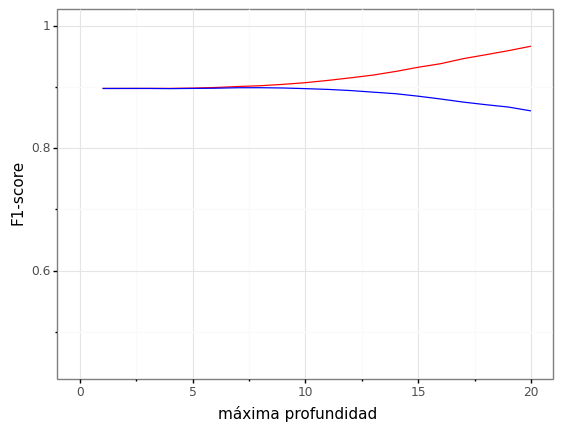

<ggplot: (8771174198605)>

In [187]:
#Graficando los errores
maxDepthTemp=max(resultados.maxDepth)
print(resultados.columns)
print(maxDepthTemp)
(ggplot(resultados)+aes(x="maxDepth")+theme_bw()
 +geom_line(aes(y="meanTrain"),color="red")
 +annotate("text",x=maxDepthTemp-2,y=resultados.iloc[int(maxDepthTemp-1),0],label="Train",color="red")
 +geom_line(aes(y="meanTest"),color="blue")
 +annotate("text",x=maxDepthTemp-2,y=resultados.iloc[int(maxDepthTemp-1),2],label="Test",color="blue")
 +labs(y="F1-score",x="máxima profundidad")
 +xlim(0,20)
 +ylim(0.45,1)
)

Valores: 
F1-test:  0.8972838973916792
Recall:  1.0
Precision:  0.8137034502981135
Accuracy:  0.8137034502981135


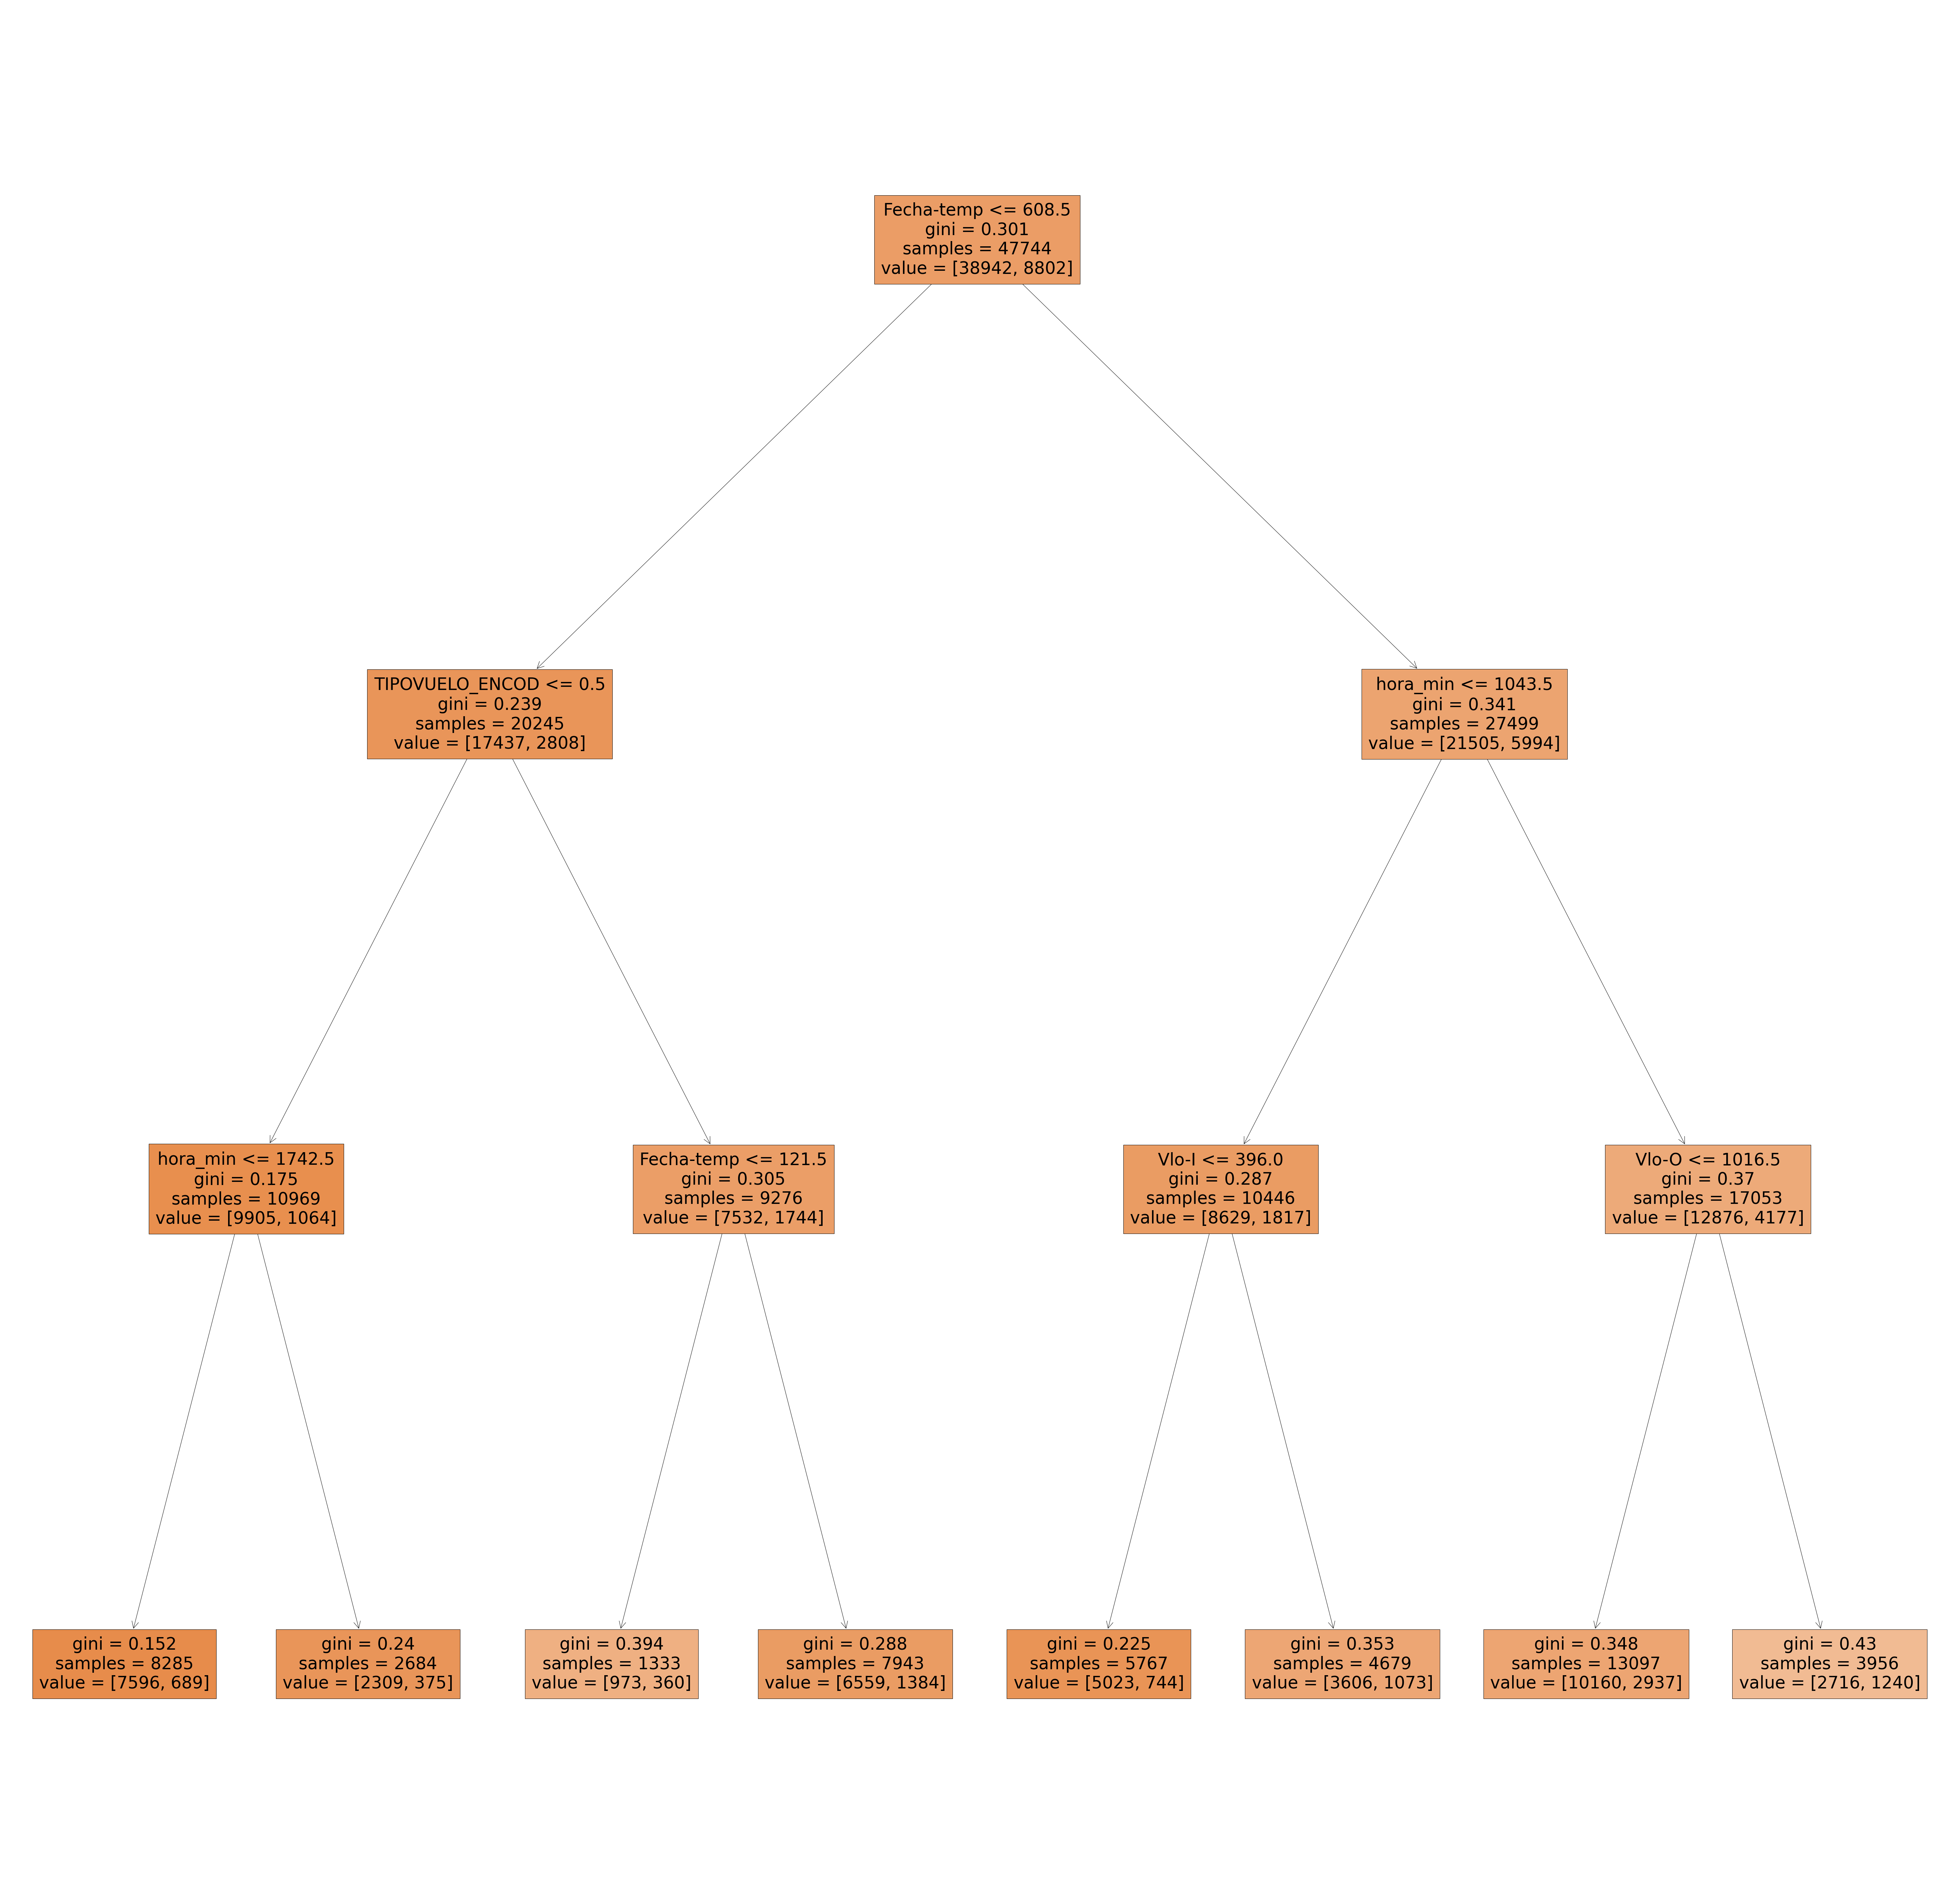

[0.12107469 0.11259724 0.         0.         0.39011642 0.18230569
 0.         0.         0.19390596 0.         0.         0.        ]


In [189]:
y = datos['atraso_15']
X = datos
X = X.drop(['atraso_15'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=0)

#Entrene el modelo con el valor de max_depth aprendido sobre todos los datos
finalModel = DecisionTreeClassifier(max_depth=3)
finalModel = finalModel.fit(X_train,y_train)

prediccionFija=finalModel.predict(X_test)

print("Valores: ")
print("F1-test: ",f1_score(y_test,prediccionFija,pos_label=False))
print("Recall: ",recall_score(y_test,prediccionFija,pos_label=False))
print("Precision: ",precision_score(y_test,prediccionFija,pos_label=False))
print("Accuracy: ",accuracy_score(y_test,prediccionFija))

#Muestre el árbol aprendido
plt.figure(figsize=(100,100)) #definiendo el tamaño de la figura
plot_tree(finalModel,filled=True,feature_names=X.columns)
plt.show() #mostrando el árbol

#¿Qué puede deducir del árbol aprendido? ¿Cuáles son las variables más importantes?
print(finalModel.feature_importances_)